# 1. Introduction
Our team created a strategy based on Kalman-filter momentum and an enhanced short-term reversal signal with lidquidty constraints. The strategy had a significant Sharpe ratio even out-of-sample.

Our strategy contains two layers of sorting. For the first sort, we grouped firms by SIC2 and then calculated equally-weighted return of firms within each group. We then used a Kalman-filter to estimate each SIC2 return's the state mean $\mu_{t-1}$ and variance $\sigma_{t-1}^2$ at $t-1$. Using these estimates, we calculated risk-adjusted returns 
$$
\mu_{t-1} - \frac{1}{2}\sigma_{t-1}^2
$$
and used this as our time $t$ investment signal. The second sort is based on the enhanced short-term reversal signal. Within this sort, the signal for longing or shorting firm $j$ is the one-month lagged spread between the returns of firm $j$'s fundamental group $r_{j, t-1}^{(f)}$ and the firm $r_{j, t-1}$. That is, investment in firm $j$ at time $t$ is based on the signal
$$
r_{j, t-1}^{(f)} - r_{j, t-1}.
$$

The fundamental return $r^{(f)}$ is calculated using similarity scores between pairs of firms. Remove pairs with a similarity score below 0.07. Of the remaining scores, remove firms whcih are similar to fewer than five other firms. For each firm $j$, its fundamental returns $r_j^{(f)}$ is the equally weighted returns of all firms which are still similar to $j$. 

There were two liquity constraints in our strategy. Remove any stock that has a rolling three-month average stock price that is less than $\$10$, and any stock whose market equity is below the 10th percentile of lagged rolling three-month market equity. We imposed these contraints to remove firms with large trading costs as well as illiquid small capitalization firms. We rolling averages of data from time $t-3$ to time $t-1$ instead of simply using time $t-1$ data because we wanted to avoid removing observations due to sharp temporary declines.   


# 2. Data Description
Our return data were obtained from the CRSP database on the WRDS website, where we also obtained gkvey and SIC code data from the COMPUSTAT database. As for creating the fundamental groups, we used the similiarity scores from the Hoberg and Philips Data Library. The return data from CRSP ranges from Jan. 31st, 1972 to Dec. 31st, 2019, and the Hoberg data covers the time period from year 1988 to year 2019.

We divided the data into training and test sets to observe the out-of-sample performance of our strategy. The training set covers the period from Jan. 31st, 1972 to Dec. 31st, 2008, and the test set covers the period from Jan. 31st, 2001 to Dec. 31st, 2019. The test set contains some overlap with the training set because the window of our Kalman-filter algothrim was 73 months (6 years plus 1 month), and therefore required some observtions in the training set to obtain an investment signal for Jan. 2009.

# 3. Training Set Data Results
For our training set, the annualized mean return of our strategy was 36.83%, with a standard deviation of 23.63%, and a skewsness of 49.39. Assuming a risk-free rate of 2%, the Sharpe ratio of our strategy in the training set was 1.47.

# 4. Test Set Data Results
For our test set, the annualized mean return of our strategy was 10.91%, with a standard deviation of 18.34%, and a skewsness 3.36. Assuming a risk-free rate of 2%, the Sharpe ratio of our strategy in the training set was 0.49.

In [6]:
# Import required packages:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import datetime as dt
import copy
import time

In [7]:
# Change directory:
import os
os.chdir("/Users/Michael Sun/Jupyterfiles")

In [8]:
# Process the stocks data from CRSP:
stocks = pd.read_csv("stocks.csv")

# Record CRSP unkowns
unknowns = ["-66.0", "-77.0", "-88.0", "-99.0", "-99.99", "-999", "A", "B",
            "C", "D", "E", "S", "T", "P"]

# Create function to convert CRISP unkowns to np.nan
convert_unknows = lambda x: np.nan if x in unknowns else x

# Convert date column to date-time object
stocks['date'] = pd.to_datetime(stocks['date'], format = '%Y%m%d')

# Shift dates to the end of the month
stocks['date'] = stocks['date'] + MonthEnd(0)

# Create a year column
stocks['year'] = stocks['date'].dt.year

# Remove missing returns
stocks['RET'] = stocks['RET'].apply(convert_unknows).astype(float).fillna(0)
stocks['DLRET'] = stocks['DLRET'].apply(convert_unknows)\
                  .astype(float).fillna(0)

# Combine delisting and regular returns
stocks['RET'] = (1 + stocks['RET']) * (1 + stocks['DLRET']) - 1

# Make sure price is positive
stocks['PRC'] = stocks['PRC'].abs()

# Remove 0-valued prices
stocks = stocks.loc[stocks['PRC'] > 0]

# Remove negative shares outstanding
stocks = stocks.loc[stocks['SHROUT'] > 0]

# Only consider stocks traded on the NYSE, NASDEQ, or AMEX
stocks = stocks.loc[stocks['SHRCD'].isin([10, 11]) & stocks['EXCHCD']\
         .isin([1, 2, 3])]

# Drop columns that have done their jobs
stocks.drop(['DLRET', 'SHRCD', 'EXCHCD', 'PERMCO'], axis = 1, inplace = True)

In [11]:
# Use the link table to connect stocks with their SIC codes:
# Import the link table:
link = pd.read_csv("link.csv")

# Clean the link table data:
link['LINKDT'] = link['LINKDT'].apply(convert_unknows)

# Correct the data format in the link table:
link['LINKDT'] = pd.to_datetime(link['LINKDT'], format = "%Y-%m-%d")

link['LINKENDDT'] = link['LINKENDDT'].apply(convert_unknows)
link['LINKENDDT'] = pd.to_datetime(link['LINKENDDT'], format = "%Y-%m-%d")

# Fill missing with date out of range:
link['LINKENDDT'] = link['LINKENDDT'].fillna(pd.to_datetime('20200901', 
                                                            format = "%Y%m%d"))

# Only keep LINKPRIM of P and C:
link = link.loc[link['LINKPRIM'].isin(["P", "C"])]

# Only consider LIID of 01:
link = link.loc[link["LIID"] == '01']

# Import the SIC codes data from Compustats:
df = pd.read_csv("sic_codes.csv")

# Merge df with link table:
df = df.merge(link, on = "gvkey")

# Extract the year from the datadate column:
df['datadate'] = pd.to_datetime(df['datadate'], format = "%Y/%m/%d")
df['year'] = df['datadate'].dt.year

# Verify that date within valid range:
df = df.loc[(df['LINKDT'] < df['datadate']) & 
            (df['datadate'] < df['LINKENDDT'])]

# Drop unneeded variables:
df = df.drop(['conm', 'LINKPRIM', 'LIID', 'fyear', 'datadate',
              "LINKDT", "LINKENDDT"], axis = 1)

# Merge df and CRSP (stocks) data:
df = stocks.merge(df, left_on = ['PERMNO', 'year'], 
                      right_on = ['LPERMNO', 'year'], how = "left")

# Reset the index of the dataframe:
df.reset_index(drop = True, inplace = True)

# Drop duplicates
df.drop_duplicates(inplace = True)

# Only consider LC link when duplicates
df['count'] = df[['date', 'PERMNO', 'LPERMCO']].groupby(['date', 'LPERMCO'])\
    .transform('count')

# If duplicates, only consider the LC link
df = df.loc[(df['count'] < 2) | (df['LINKTYPE'] == 'LC')]

# Forward fill SIC
df['sic'] = df.groupby('PERMNO')['sic'].transform(lambda x: x.ffill())


# Drop unneeded variables:
df = df.drop(["LINKTYPE", "LPERMNO", "LPERMCO", "count"], axis = 1)

    PERMNO       date     PRC       RET  SHROUT  year   gvkey     sic
0    12160 1977-01-31  4.5000  0.000000  1425.0  1977  1342.0  6799.0
1    12160 1977-01-31  4.5000  0.000000  1425.0  1977  2767.0  6141.0
2    12160 1977-02-28  4.8750  0.083333  1425.0  1977  1342.0  6799.0
3    12160 1977-02-28  4.8750  0.083333  1425.0  1977  2767.0  6141.0
4    12160 1977-03-31  4.2500 -0.128205  1425.0  1977  1342.0  6799.0
5    12160 1977-03-31  4.2500 -0.128205  1425.0  1977  2767.0  6141.0
6    12160 1977-04-30  4.5625  0.073529  1425.0  1977  1342.0  6799.0
7    12160 1977-04-30  4.5625  0.073529  1425.0  1977  2767.0  6141.0
8    12160 1977-05-31  4.8125  0.054795  1425.0  1977  1342.0  6799.0
9    12160 1977-05-31  4.8125  0.054795  1425.0  1977  2767.0  6141.0
10   12160 1977-06-30  4.8125  0.000000  1425.0  1977  1342.0  6799.0
11   12160 1977-06-30  4.8125  0.000000  1425.0  1977  2767.0  6141.0
12   12160 1977-07-31  4.8125  0.000000  1425.0  1977  1342.0  6799.0
13   12160 1977-07-3

# Process the SIC Codes
The SIC codes in our data were in 4 digits. Given that we were only interested in the major industry sector to which the firm belonged, and we wanted to reduce the computational complexity of our code, we truncated the SIC codes to their first two digits.

In [12]:
# Prepare the data for running the Kalman-filter algorithm:
# Rename the dataframe so as to indicate that the data cleaning process
# is over:
stocks_kf = copy.deepcopy(df)

# Fill individual missing stock returns with 0's:
stocks_kf['RET'] = stocks_kf['RET'].fillna(0)

# Trim the industry code by 2 digit, reducing the number of industry 
# categories by about half to 73.
stocks_kf['sic'] = (0.01 * stocks_kf['sic']).astype('int')

# Create the industry average returns dataframe:
ind_avg_ret = pd.DataFrame(stocks_kf.groupby(['date', 'sic'])['RET'].mean())\
              .reset_index()

ind_mom = ind_avg_ret.pivot_table(values='RET', index='date', columns='sic')\
          .reset_index()        

# Train/Test split:
ind_kf_train = ind_mom[ind_mom['date'].dt.year <= 2008]

# Implementation of the Kalman-filter Algorithm

1. The length of the Kalman window must be greater than or equal to the number of industry groups, which is 73.

2. Before we initialize the Kalman-filter, we eliminate industries where more than 25% of the observations are missing.

3. Initialization of the Kalman-filter parameters: 1) Initial state means of zeros. 2) Initial state covariance: Variance within industry is 0.01, and the covariance between industries is zero. 3) Transition matrice and transition covariance to be $I$ (the identity matrix), because we held the naive expectation that the returns do not change over time. 4) The observation matrix is the identity matrix because our theorical measurement units are the same as the output units. 

4. We use the _em_ method with five iterations to estimate the maximum likelihood parameters of given the data contained within the Kalman window.

5. When the Kalman-filter throws an error, we simply assume the state mean estimates and error have zeros for all of their entries.

6. The investment signal for investment at time $t$ is the state mean estimate minus half of the variance of the estimate at time $t-1$.

In [13]:
# Implement the Kalman Filter algorithm:

# Define window for Kalman filter
kal_win = len(ind_kf_train.columns) - 1

# Create data frame to record signal values
kal_mom = pd.DataFrame(index = ind_kf_train.index[kal_win:], 
                       columns = ind_kf_train.columns)

# We will loop over the date
dates = np.unique(ind_kf_train['date'])[kal_win:]

for date in dates:
    
    # Obtain the end of the signal formation, exclusive
    stop = np.sum(ind_kf_train['date'] < date)
    
    # Record the beginning of signal, inclusive
    start = stop - kal_win
    
    # Get 'measurement' values for Kalman filter
    X = np.array(ind_kf_train.iloc[start:stop, 1:])
    
    # Check for NaN values in the industry columns:
    bad_col = np.mean(X != X, axis=0) > 0.25
    X = X[:, ~bad_col]
    X = np.nan_to_num(X)
    

    # Record the number of variables
    n = X.shape[1]

    # Save identity matrix
    I = np.eye(n)

    # Initialize Kalman filter:
    kf = KalmanFilter(initial_state_mean = np.zeros(n),
                      initial_state_covariance =  0.10**2 * I,
                      transition_matrices = I,
                      transition_covariance = I,
                      observation_matrices = I,
                      observation_covariance = 0.10**2 * I
                      )    

    try:
        
        kf = kf.em(X, n_iter = 5)
        mu, sigma = kf.smooth(X)
    
    except:
        
        # If det(X'X) is too small for Kalman filter, use 0 as state estimates
        mu, sigma = [np.zeros(n)], [np.zeros((n, n))]
    
    # Record date for later merger
    kal_mom.loc[stop, 'date'] = date    
    
    # Record signal
    col_sel = np.concatenate([[False], ~bad_col])
    kal_mom.loc[stop, col_sel] = mu[-1] - 0.5 * np.diag(sigma[-1])

sic,date,1,2,7,8,10,12,13,14,15,...,79,80,81,82,83,84,86,87,89,99
423,2008-03-31T00:00:00.000000000,-0.00501455,0.134917,-0.145774,NaN,0.112989,0.121508,0.0558431,0.0544283,-0.0229287,...,-0.0779173,-0.0446223,-0.0934145,-0.0999065,-0.039927,NaN,NaN,-0.031531,NaN,-0.0194228
424,2008-04-30T00:00:00.000000000,0.0205504,0.123196,0.0796248,NaN,-0.0575531,0.014614,0.00610345,-0.0155961,0.0478385,...,-0.077038,-0.0462858,-0.130089,-0.0783888,-0.0855723,NaN,NaN,-0.0366406,NaN,0.00463534
425,2008-05-31T00:00:00.000000000,0.0302397,0.0998378,0.168027,NaN,-0.0103779,0.167102,0.101131,0.0153573,0.0059715,...,0.0123348,0.0264589,0.0166527,0.0756831,0.0729829,NaN,NaN,0.0400837,NaN,0.0121397
426,2008-06-30T00:00:00.000000000,0.0195338,0.00253912,0.00154827,NaN,0.0370393,0.284307,0.161965,0.025213,-0.0597845,...,0.0361395,0.0293573,0.0145266,0.0308744,0.0202337,NaN,NaN,0.0218329,NaN,0.019011
427,2008-07-31T00:00:00.000000000,-0.0590555,0.00403602,-0.119325,NaN,-0.0492495,0.219088,0.100298,-0.031285,-0.178053,...,-0.132697,-0.047836,-0.00636484,-0.0512639,-0.0114246,NaN,NaN,-0.0608194,NaN,-0.0825146
428,2008-08-31T00:00:00.000000000,-0.0061223,0.0380362,-0.0364432,NaN,-0.103278,-0.0228355,-0.0960602,-0.0314479,0.00434646,...,-0.0360831,0.0240523,0.0458793,0.0755852,-0.0633831,NaN,NaN,0.0179925,NaN,0.00389754
429,2008-09-30T00:00:00.000000000,0.024352,-0.0487693,0.014308,NaN,-0.123488,-0.0199587,-0.0401122,-0.027419,0.0612066,...,0.0460643,0.0642785,0.0627713,0.0443065,0.119195,NaN,NaN,0.0375399,NaN,0.000258628
430,2008-10-31T00:00:00.000000000,0.00110432,-0.294029,-0.0556076,NaN,-0.268315,-0.339033,-0.209141,-0.137677,0.00535014,...,-0.141202,-0.0851252,-0.225472,-0.0964682,-0.0998545,NaN,NaN,-0.125313,NaN,-0.130828
431,2008-11-30T00:00:00.000000000,-0.127654,-0.208178,-0.171761,NaN,-0.431592,-0.339161,-0.302123,-0.163929,-0.215395,...,-0.282839,-0.181625,-0.111857,-0.0929053,-0.29266,NaN,NaN,-0.24638,NaN,-0.151925
432,2008-12-31T00:00:00.000000000,-0.113874,-0.30545,-0.0741011,NaN,-0.140718,-0.338191,-0.206386,-0.101583,-0.185592,...,-0.199264,-0.146178,0.043912,-0.00681131,-0.387842,NaN,NaN,-0.122163,NaN,-0.106194


In [14]:
# Change structure of data frame so industries are observations:
kal_mom = pd.melt(kal_mom, id_vars = ['date'], 
                  value_vars = kal_mom.columns[1:])
 
# Change column names
kal_mom.columns = ['date', 'sic', 'Kal_mom']

        date sic    Kal_mom
0 1979-01-31   1  0.0186899
1 1979-02-28   1  0.0823478
2 1979-03-31   1 -0.0275645
3 1979-04-30   1  0.0902015
4 1979-05-31   1  0.0472942


In [15]:
# Change structure of data frame so industries are observations
ind_kf_train = pd.melt(ind_kf_train, id_vars = ['date'], 
                       value_vars = ind_kf_train.columns[1:])

# Change column names
ind_kf_train.columns = ['date', 'sic', 'RET']

        date sic       RET
0 1972-12-31   1 -0.007486
1 1973-01-31   1 -0.083458
2 1973-02-28   1 -0.052133
3 1973-03-31   1 -0.057850
4 1973-04-30   1 -0.080605


# Grouping the Industries Based on the Kalman Momentum Signal
We splitted the industries into tercile groups based on the Kalman momentum signal. We decided to use terciles after we had tried a few division methods such as deciles and quintiles, and then found that terciles had the best outcomes in the training set. We longed the third tercile and short the first tercile.

In [16]:
# Merge the Kalman-filter algothrithm results with the training industry Kalman-filter data frame:
kf_res = ind_kf_train.merge(kal_mom, on = ['date', 'sic'])

# Calculate terciles:
kf_res['tercile'] = kf_res[['date', 'Kal_mom']].groupby('date')['Kal_mom']\
                    .transform(lambda x: pd.qcut(x, 3, labels = False))

# Add 1 to terciles to avoid confusion:
kf_res['tercile'] = 1 + kf_res['tercile']

# Drop columns that have done their jobs:
kf_res.drop(['Kal_mom'], axis = 1, inplace = True)

             mean        sd       skew
tercile                               
1.0      0.097808  0.204847 -28.156659
2.0      0.127890  0.185315 -34.705044
3.0      0.193207  0.190484 -27.000916
WML      0.095399  0.099193  18.831968


<ipython-input-16-0e6f957a39cc>:28: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  stats['mean'] = 12 * result.mean()


# Process the Hoberg Data
1. We omitted similarity score to less than or equal to 0.07. 

2. We lagged our similarity score observation by 1 year to avoid a forward-looking bias. 

In [18]:
# Second sort based on Fundamental Return Spread:
# 1. Load the Hoberg data:
hoberg_file = 'hoberg_data.txt'

hoberg = pd.read_csv(hoberg_file, delimiter='\t')

# 2. Set similarity score to be greater than 0.07:
hoberg = hoberg.loc[hoberg['score'] > 0.07, :]

# 3. Remove the score column:
hoberg.drop('score', axis=1, inplace=True)

# 4. Merge the hoberg data with the df dataframe:
df2 = copy.deepcopy(df)    

df2.drop(['sic', 'PRC', 'SHROUT'], axis=1, inplace=True)

df2.rename(columns = {'RET': 'RET2', 'gvkey': 'gvkey2', 'PERMNO': 'PERMNO2'},
           inplace=True)

# Add 1 to the year in the hoberg data:
hoberg['year'] = hoberg['year'] + 1

df_hoberg = df.merge(hoberg, left_on=['year', 'gvkey'], 
                     right_on=['year', 'gvkey1'])

del(hoberg)

df_hoberg.drop('year', axis=1, inplace=True)

df_hoberg = df_hoberg.merge(df2, on = ['gvkey2', 'date'])

df_hoberg = df_hoberg.loc[df_hoberg['PERMNO'] != df_hoberg['PERMNO2'], :]

# 5. Compute the number of firms in each fundamental group:
df_hoberg['N'] = df_hoberg.groupby(['date', 'PERMNO'])['PERMNO2']\
                 .transform('count')

# 6. Compute the fundamental group returns:                 
df_hoberg['fun_ret'] = df_hoberg.groupby(['date', 'PERMNO'])['RET2']\
                       .transform('mean')
                       
# 7. Clean up the merged hoberg data:
df_hoberg = df_hoberg.drop(['gvkey', 'gvkey2', 'PERMNO2', 'RET2'], axis=1)

df_hoberg.drop_duplicates(inplace=True)

df_hoberg.reset_index(drop=True, inplace=True)

# 8. Trim the industry code by 2 digit:
df_hoberg['sic'] = (0.01 * df_hoberg['sic']).astype('int')

# 9. Compute the spread, then shift the observation by 1 period:
df_hoberg['spread'] = df_hoberg['fun_ret'] - df_hoberg['RET']

df_hoberg.sort_values(['PERMNO', 'date'], inplace=True)

df_hoberg['lag_spread'] = df_hoberg.groupby('PERMNO')['spread']\
                          .shift(periods=1)

# Impose the Liquity Constraints

In [19]:
# Impose the liquidity constraints:

# 10. Compute the 3-month rolling averge of lagged market equity:
df_hoberg['lag_PRC'] = df_hoberg.groupby('PERMNO')['PRC'].shift(periods=1)

df_hoberg['lag_SHROUT'] = df_hoberg.groupby('PERMNO')['SHROUT']\
                          .shift(periods=1)

df_hoberg['lag_ME'] = df_hoberg['lag_PRC'] * df_hoberg['lag_SHROUT']

df_hoberg['Avg_lag_ME_tm'] = df_hoberg.groupby('PERMNO')['lag_ME']\
                             .transform(lambda x: x.rolling(3).mean())

# 11. Compute the 3-month rolling averge of prices:
df_hoberg['Avg_PRC_tm'] = df_hoberg.groupby('PERMNO')['PRC']\
                          .transform(lambda x: x.rolling(3).mean())

# 12. Check the 1-month validity and 3-month validity of observations:
df_hoberg['om_valid'] = df_hoberg['date'].shift() + dt.timedelta(days = 7)\
                     + MonthEnd(0) == df_hoberg['date'] + MonthEnd(0)

df_hoberg.loc[df_hoberg['om_valid'] == False, 'lag_spread'] = np.nan    
    
df_hoberg['tm_valid'] = df_hoberg['date'].shift(3) + dt.timedelta(days = 7)\
                     + MonthEnd(3) == df_hoberg['date'] + MonthEnd(0)

df_hoberg.loc[df_hoberg['tm_valid'] == False, 
              ['Avg_lag_ME_tm', 'Avg_PRC_tm']] = np.nan

# 13. Remove NaN observations in lag spread, average lag ME, and average
# price:
df_hoberg = df_hoberg[(df_hoberg['lag_spread'].notna()) & 
                      (df_hoberg['Avg_lag_ME_tm'].notna()) & 
                      (df_hoberg['Avg_PRC_tm'].notna())]

df_hoberg.drop(['om_valid', 'tm_valid'], axis=1, inplace=True)

# 14. Check if the 3-month rolling averge of prices is greater than $10:
price_level = 10
    
df_hoberg['PRC_valid'] = df_hoberg['Avg_PRC_tm'] >= price_level  

# 15. Check if the 3-month rolling averge of lagged ME is at the 90th
# percentile or higher.
df_hoberg['lag_ME_np'] = df_hoberg.groupby('date')['Avg_lag_ME_tm']\
                         .transform(lambda x: x.quantile(q=0.2))
                         
df_hoberg['ME_valid'] = df_hoberg['Avg_lag_ME_tm'] >= df_hoberg['lag_ME_np']                         

# 16. Filter the data based on N values, average price, and average ME:
df_hoberg = df_hoberg[(df_hoberg['N'] >= 5) & 
                      (df_hoberg['PRC_valid']) &
                      (df_hoberg['ME_valid'])]

df_hoberg.drop(['PRC', 'SHROUT', 'gvkey1', 'year', 'N', 'fun_ret', 'spread',
                'lag_PRC', 'lag_SHROUT', 'lag_ME', 'Avg_lag_ME_tm', 
                'Avg_PRC_tm', 'PRC_valid', 'lag_ME_np', 'ME_valid'],
               axis = 1, inplace = True)

# Implement Decile Sort Based on the Peleg Signal
1. We divided the 3rd and the 1st terciles of the industries groups resulted from the Kalman momentum signal to quintiles, and therefore created a decile sort based on the Peleg signal. The 6th to 10th deciles came from the 3rd tercile of the Kalman momentum sort, and the 1st to 5th deciles came from the 1st tercile of the Kalman momentum sort. We then longed the 10th decile and short the 1st decile. 

2. Explanation of the "Peleg Signal": It's a version of short-term reversal based on the difference between the fundamental group's return and the individual firm's return at $t-1$. The idea is that if the firm's return is much less than its fundamental group return in period $t-1$, then we would expect the firm's price to be "corrected" in the next period $t$. 

In [20]:
# Combine the results of the second sort and the results of the Kalman-filter algothrim:

# 17. Select the winning/losing sic codes from the Kalman Filter results:
kf_res_win = kf_res[kf_res['tercile'] == 3]

kf_res_los = kf_res[kf_res['tercile'] == 1]

# 18. Filter out the winners from the hoberg data:
hoberg_kf_win = pd.merge(kf_res_win, df_hoberg, on = ['date', 'sic'])

hoberg_kf_los = pd.merge(kf_res_los, df_hoberg, on = ['date', 'sic'])

hoberg_kf_win.drop(['RET_x', 'tercile'], axis = 1, inplace = True)

hoberg_kf_los.drop(['RET_x', 'tercile'], axis = 1, inplace = True)

# 19. Decile sort on the winning/losing end:
hoberg_kf_win['decile'] = hoberg_kf_win.groupby('date')['lag_spread']\
                            .transform(lambda x: pd.qcut(x, 5, labels = False))
                            
hoberg_kf_los['decile'] = hoberg_kf_los.groupby('date')['lag_spread']\
                            .transform(lambda x: pd.qcut(x, 5, labels = False))
                            
# Add 1 to quintile to avoid confusion
hoberg_kf_win['decile'] = 6 + hoberg_kf_win['decile']

hoberg_kf_los['decile'] = 1 + hoberg_kf_los['decile']

# 20. Perform the second sort:
hoberg_kf_win = hoberg_kf_win[hoberg_kf_win['decile'] == 10]

hoberg_kf_los = hoberg_kf_los[hoberg_kf_los['decile'] == 1]

# 21. Combine the winners and losers to a single dataframe:
hoberg_kf_df = pd.concat([hoberg_kf_win, hoberg_kf_los],
                         axis=0, ignore_index=True)

We will annualize our returns under the assumption that they are independent and identically distributed. We will also ignore compounding effects. Under these assumptions, the conversions are as follows
\begin{align*}
    \mu_{\text{annual}} &\approx 12\times\mu_{\text{monthly}}\\
    \sigma_{\text{annual}} &\approx \sqrt{12}\times\sigma_{\text{monthly}}\\
    \mathcal{Sk}_{\text{annual}} &\approx 12\sqrt{12}\times \mathcal{Sk}_{\text{monthly}}.
\end{align*}
The annualization is only intended to give a sense of scale.

In [21]:
# 22. Compute the results:
hoberg_kf_res = hoberg_kf_df.groupby(['date', 'decile'])['RET_y'].mean()\
                .reset_index()

hoberg_kf_res = hoberg_kf_res.pivot(index = 'date', columns = 'decile',
                                    values = 'RET_y').reset_index()

# Calculate winners minus losers
hoberg_kf_res['WML'] = hoberg_kf_res[10] - hoberg_kf_res[1]

# Create data frame for return statistics
hoberg_stats = pd.DataFrame(index = hoberg_kf_res.columns[1:])

# Compute the annualized mean returns:
hoberg_stats['mean'] = 12 * hoberg_kf_res.mean()

# Compute the annualized standard deviation:
hoberg_stats['sd'] = np.sqrt(12) * hoberg_kf_res.std()

# Compute the annualized skew:
hoberg_stats['skew'] = 12**(3/2) * hoberg_kf_res.skew()

# Print the result statistics:
print(hoberg_stats)

            mean        sd       skew
decile                               
1.0    -0.051208  0.221423 -21.641748
10.0    0.317053  0.249087  37.908907
WML     0.368262  0.236257  49.390523


<ipython-input-21-c407f8a742e7>:15: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  hoberg_stats['mean'] = 12 * hoberg_kf_res.mean()


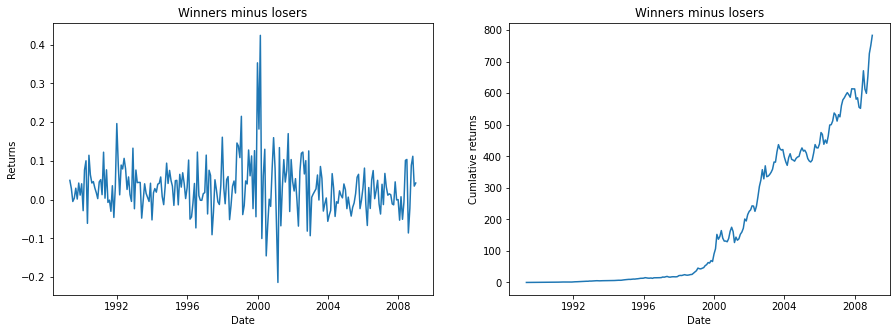

In [22]:
# Plot returns：
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

ax1.plot(hoberg_kf_res['date'], hoberg_kf_res['WML'])
ax1.set_xlabel('Date') 
ax1.set_ylabel('Returns') 
ax1.set_title('Winners minus losers') 

ax2.plot(hoberg_kf_res['date'], (1 + hoberg_kf_res['WML']).cumprod() - 1) 
ax2.set_xlabel('Date') 
ax2.set_ylabel('Cumlative returns') 
ax2.set_title('Winners minus losers') 

plt.show()